### BDT benchmark

In [1]:
# Stdlib packages
import copy
import datetime
import glob
import json
import os
import re
from pathlib import Path

# Common Py packages
import numpy as np
from matplotlib import pyplot as plt
from prettytable import PrettyTable

# HEP packages
import gpustat
import h5py
import hist
import mplhep as hep
import xgboost as xgb
from cycler import cycler


# ML packages
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import auc, roc_curve

# Module packages
from data_processing import process_data, data_list_index_map

gpustat.print_gpustat()

plt.style.use(hep.style.CMS)
plt.rcParams.update({'font.size': 20})
cmap_petroff10 = ["#3f90da", "#ffa90e", "#bd1f01", "#94a4a2", "#832db6", "#a96b59", "#e76300", "#b9ac70", "#717581", "#92dadd"]
plt.rcParams.update({"axes.prop_cycle": cycler("color", cmap_petroff10)})

cmslpcgpu3.fnal.gov      Tue Oct 15 13:32:01 2024  555.42.06
[0] Tesla P100-PCIE-12GB | 53°C,  39 % |  3162 / 12288 MB | ckapsiak(3160M)


In [2]:
lpc_fileprefix = "/eos/uscms/store/group/lpcdihiggsboost/tsievert/HiggsDNA_parquet/v1"

V2_MERGED = True

SIGNAL_FILEPATHS = [
    # Test sig files #
    # '/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_official/output_test_HH/Run3_2022preEE/GluGluToHH/nominal/*',
    # '/uscms/home/tsievert/nobackup/XHYbbgg/HiggsDNA_official/output_test_HH/Run3_2022preEE_merged_v2/GluGluToHH/nominal/*',
    # ggF HH # 
    lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GluGluToHH/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GluGluToHH/nominal/*",
    # VBF HH #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/VBFHHto2B2G_CV_1_C2V_1_C3_1/nominal/*",
]
BKG_FILEPATHS = [
    # ttH (i.e. the main bkg to reduce) #
    lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/ttHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/ttHToGG/nominal/*",
    # # Other single H samples #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GluGluHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GluGluHToGG/nominal/*",
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/VBFHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/VBFHToGG/nominal/*",
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/VHToGG/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/VHToGG/nominal/*",
    # # Prompt-Prompt samples #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GGJets/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GGJets/nominal/*",
    # # Prompt-Fake samples #
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GJetPt20To40/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GJetPt20To40/nominal/*",
    # lpc_fileprefix+f"/Run3_2022preEE_merged{'_v2' if V2_MERGED else ''}/GJetPt40/nominal/*", lpc_fileprefix+f"/Run3_2022postEE_merged{'_v2' if V2_MERGED else ''}/GJetPt40/nominal/*",
    # Fake-Fake samples #
    # ADD HERE #
]


CURRENT_DIRPATH = str(Path().absolute())
VERSION = 'v9'
N_PARTICLES, N_PARTICLE_FIELDS = 6, 7
MOD_VALS = (5, 5)
VARS = 'extra_vars+'
OUTPUT_DIRPATH = CURRENT_DIRPATH + f"/BDT_model_outputs/{VERSION}/{VARS}/"

if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

SEED = 21
OPTIMIZE_SPACE = False
NUM_EPOCHS = 150

In [3]:
def training_weights(event_weights, labels):
    sum_of_bkg = np.sum(event_weights[labels==0])
    sum_of_sig = np.sum(event_weights[labels==1])

    sig_scale_factor = sum_of_bkg / sum_of_sig

    weights = np.where(labels==0, event_weights, event_weights*sig_scale_factor)
    mean_weight = np.mean(weights)
    abs_weights = np.abs(weights)
    scaled_weights = abs_weights / mean_weight

    return scaled_weights

In [4]:
(
    data_df_dict, data_test_df_dict, 
    data_list_dict, data_hlf_dict, label_dict, 
    data_list_test_dict, data_hlf_test_dict, label_test_dict, 
    high_level_fields_dict, input_hlf_vars_dict, hlf_vars_columns_dict,
    data_aux_dict, data_test_aux_dict
) = process_data(
    N_PARTICLES, N_PARTICLE_FIELDS, SIGNAL_FILEPATHS, BKG_FILEPATHS, OUTPUT_DIRPATH, seed=SEED, mod_vals=MOD_VALS, k_fold_test=True
)

weight_train_dict = {
    f"fold_{fold_idx}": copy.deepcopy(training_weights(data_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy(), label_dict[f'fold_{fold_idx}'])) for fold_idx in range(len(data_test_aux_dict))
}
weight_test_dict = {
    f'fold_{fold_idx}': copy.deepcopy(data_test_aux_dict[f'fold_{fold_idx}'].loc[:, "eventWeight"].to_numpy()) for fold_idx in range(len(data_test_aux_dict))
}

/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Data list: (413735, 6, 7)
Data HLF: (413735, 15)
n signal = 136530, n bkg = 277205
Data list test: (103521, 6, 7)
Data HLF test: (103521, 15)
n signal = 34224, n bkg = 69297


/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Data list: (413918, 6, 7)
Data HLF: (413918, 15)
n signal = 136466, n bkg = 277452
Data list test: (103338, 6, 7)
Data HLF test: (103338, 15)
n signal = 34288, n bkg = 69050


/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Data list: (413265, 6, 7)
Data HLF: (413265, 15)
n signal = 136638, n bkg = 276627
Data list test: (103991, 6, 7)
Data HLF test: (103991, 15)
n signal = 34116, n bkg = 69875


/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Data list: (413725, 6, 7)
Data HLF: (413725, 15)
n signal = 136671, n bkg = 277054
Data list test: (103531, 6, 7)
Data HLF test: (103531, 15)
n signal = 34083, n bkg = 69448


/uscms/home/tsievert/nobackup/miniconda3/envs/higgs-dna-hhbbgg/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Data list: (414381, 6, 7)
Data HLF: (414381, 15)
n signal = 136711, n bkg = 277670
Data list test: (102875, 6, 7)
Data HLF test: (102875, 15)
n signal = 34043, n bkg = 68832


In [5]:
print(weight_train_dict[f"fold_0"])

[2.15334762 2.33088447 2.15334762 ... 1.70663454 2.15334762 2.15334762]


In [55]:
bdt_train_dict, bdt_val_dict, bdt_test_dict = {}, {}, {}
for fold_idx in range(len(data_df_dict)):
    (
        X_train, X_val, y_train, y_val, weight_train, weight_val
    ) = train_test_split(
        data_df_dict[f"fold_{fold_idx}"].to_numpy(), label_dict[f"fold_{fold_idx}"], weight_train_dict[f"fold_{fold_idx}"],
        test_size=0.2, random_state=21
    )

    bdt_train_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=X_train, label=y_train, 
        weight=weight_train,
        missing=-999.0, feature_names=data_df_dict[f"fold_{fold_idx}"].columns
    )
    bdt_val_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=X_val, label=y_val, 
        weight=weight_val,
        missing=-999.0, feature_names=data_df_dict[f"fold_{fold_idx}"].columns
    )
    
    bdt_test_dict[f"fold_{fold_idx}"] = xgb.DMatrix(
        data=data_test_df_dict[f"fold_{fold_idx}"].to_numpy(), label=label_test_dict[f"fold_{fold_idx}"], 
        weight=np.abs(weight_test_dict[f"fold_{fold_idx}"]),
        missing=-999.0, feature_names=data_test_df_dict[f"fold_{fold_idx}"].columns
    )

    print(f"fold {fold_idx}")
    print(f"Num train: {len(y_train)} -> {sum(y_train == 1)} sig & {sum(y_train == 0)} bkg")
    print(f"Num val: {len(y_val)} -> {sum(y_val == 1)} sig & {sum(y_val == 0)} bkg")
    print(f"Num test: {len(label_test_dict[f'fold_{fold_idx}'])} -> {sum(label_test_dict[f'fold_{fold_idx}'] == 1)} sig & {sum(label_test_dict[f'fold_{fold_idx}'] == 0)} bkg")
    print('='*60)

    

fold 0
Num train: 330988 -> 109160 sig & 221828 bkg
Num val: 82747 -> 27370 sig & 55377 bkg
Num test: 103521 -> 34224 sig & 69297 bkg
fold 1
Num train: 331134 -> 109309 sig & 221825 bkg
Num val: 82784 -> 27157 sig & 55627 bkg
Num test: 103338 -> 34288 sig & 69050 bkg
fold 2
Num train: 330612 -> 109498 sig & 221114 bkg
Num val: 82653 -> 27140 sig & 55513 bkg
Num test: 103991 -> 34116 sig & 69875 bkg
fold 3
Num train: 330980 -> 109274 sig & 221706 bkg
Num val: 82745 -> 27397 sig & 55348 bkg
Num test: 103531 -> 34083 sig & 69448 bkg
fold 4
Num train: 331504 -> 109348 sig & 222156 bkg
Num val: 82877 -> 27363 sig & 55514 bkg
Num test: 102875 -> 34043 sig & 68832 bkg


In [46]:
param = {}

# Booster parameters
param['eta']              = 0.01 # learning rate
param['max_depth']        = 5  # maximum depth of a tree
param['subsample']        = 0.5 # fraction of events to train tree on
param['colsample_bytree'] = 0.5 # fraction of features to train tree on

# Learning task parameters
param['objective']   = 'binary:logistic' # objective function
param['eval_metric'] = 'error'           # evaluation metric for cross validation
param = list(param.items()) + [('eval_metric', 'logloss')]



num_trees = 1000  # number of trees to make

In [47]:
CURRENT_TIME = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
OUTPUT_DIRPATH = os.path.join(OUTPUT_DIRPATH, CURRENT_TIME)
if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

for fold_idx in range(len(bdt_train_dict)):
    print(f"fold {fold_idx}")
    # Train bdt
    evallist = [(bdt_train_dict[f"fold_{fold_idx}"], 'train'), (bdt_val_dict[f"fold_{fold_idx}"], 'val')]
    booster = xgb.train(
        param, bdt_train_dict[f"fold_{fold_idx}"], num_boost_round=num_trees, 
        evals=evallist, early_stopping_rounds=7, verbose_eval=True
    )
    booster.save_model(os.path.join(OUTPUT_DIRPATH, f'{CURRENT_TIME}_BDT_fold{fold_idx}.model'))
    
    # Print perf on test dataset
    print(booster.eval(bdt_test_dict[f"fold_{fold_idx}"]))
    print('='*100)

fold 0
[0]	train-error:0.12758	train-logloss:0.68692	val-error:0.12918	val-logloss:0.68699
[1]	train-error:0.12256	train-logloss:0.68099	val-error:0.12419	val-logloss:0.68108
[2]	train-error:0.12148	train-logloss:0.67529	val-error:0.12276	val-logloss:0.67541
[3]	train-error:0.11979	train-logloss:0.66962	val-error:0.12161	val-logloss:0.66978
[4]	train-error:0.11622	train-logloss:0.66482	val-error:0.11822	val-logloss:0.66499
[5]	train-error:0.11622	train-logloss:0.65935	val-error:0.11775	val-logloss:0.65956
[6]	train-error:0.11271	train-logloss:0.65450	val-error:0.11415	val-logloss:0.65472
[7]	train-error:0.11196	train-logloss:0.64910	val-error:0.11318	val-logloss:0.64936
[8]	train-error:0.11364	train-logloss:0.64409	val-error:0.11490	val-logloss:0.64436
[9]	train-error:0.11507	train-logloss:0.63904	val-error:0.11639	val-logloss:0.63934
[10]	train-error:0.11324	train-logloss:0.63598	val-error:0.11449	val-logloss:0.63629
[11]	train-error:0.11341	train-logloss:0.63085	val-error:0.11459	val

In [49]:
# OUTPUT_DIRPATH = os.path.join(OUTPUT_DIRPATH, CURRENT_TIME)
if not os.path.exists(OUTPUT_DIRPATH):
    os.makedirs(OUTPUT_DIRPATH)

BDT_perf = {
    'preds': [], 'fprs': [], 'tprs': [], 'thresholds': [], 'areas': []
}
base_tpr = np.linspace(0, 1, 5000)  # copied from IN evaluate.py file
for fold_idx in range(len(bdt_train_dict)):
    BDT_perf['preds'].append(booster.predict(bdt_test_dict[f"fold_{fold_idx}"]).tolist())

    fpr_bdt, tpr_bdt, threshold_bdt = roc_curve(label_test_dict[f"fold_{fold_idx}"], BDT_perf['preds'][-1])
    fpr_bdt = np.interp(base_tpr, tpr_bdt, fpr_bdt)
    threshold_bdt = np.interp(base_tpr, tpr_bdt, threshold_bdt)
    BDT_perf['fprs'].append(fpr_bdt.tolist())
    BDT_perf['tprs'].append(tpr_bdt.tolist())
    BDT_perf['thresholds'].append(threshold_bdt.tolist())

    BDT_perf['areas'].append(float(auc(fpr_bdt, base_tpr)))

    with h5py.File(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+f"_BDT_ROC_fold{fold_idx}.h5"), "w") as out:
        out['FPR'] = fpr_bdt
        out['TPR'] = tpr_bdt
        out['Thresholds'] = threshold_bdt

with open(os.path.join(OUTPUT_DIRPATH, CURRENT_TIME+"_BDT_perf.json"), 'w') as f:
    json.dump(BDT_perf, f)

In [50]:
def plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='png'):
    plot_prefix = plot_prefix + ('_' if plot_prefix != '' else '')
    plot_postfix = plot_postfix + ('_' if plot_postfix != '' else '')
    plot_name = plot_prefix + plot_name + plot_postfix + f'.{format}'

    plot_filepath = os.path.join(plot_dirpath, plot_name)
    return plot_filepath

def plot_rocs(
    fprs, tprs, labels, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix=''
):
    plt.figure(figsize=(9,7))
    
    for fpr, tpr, label in zip(fprs, tprs, labels):
        linestyle = 'solid' if re.search('IN', label) is not None else ('dashed' if re.search('BDT', label) is not None else 'dotted')
        plt.plot(fpr, tpr, label=label, linestyle=linestyle)

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Background contamination')
    plt.ylabel('Signal efficiency')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_output_scores(
    sigs, bkgs, labels, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', bins=50, weights={'sig': None, 'bkg': None}
):
    plt.figure(figsize=(9,7))

    for sig, bkg, label in zip(sigs, bkgs, labels):
        hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig))
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'] if weights['bkg'] is not None else np.ones_like(bkg))
        hep.histplot(
            [sig_hist, bkg_hist],
            yerr=(True if weights['sig'] is not None else False),
            alpha=0.7, density=(False if weights['sig'] is not None else True), histtype='step',
            label=[f'{label} - HH signal', f'{label} - ttH background']
        )

    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Output score')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

def plot_s_over_root_b(
    sigs, bkgs, labels, plot_name, plot_dirpath,
    plot_prefix='', plot_postfix='', bins=50, weights={'sig': None, 'bkg': None},
    lines=None, lines_labels=None, line_colors=None
):
    plt.figure(figsize=(9,7))

    for idx, (sig, bkg, label) in enumerate(zip(sigs, bkgs, labels)):
        linestyle = 'solid' if re.search('IN', label) is not None else ('dashed' if re.search('BDT', label) is not None else 'dotted')

        hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'] if weights['sig'] is not None else np.ones_like(sig))
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'] if weights['bkg'] is not None else np.ones_like(bkg))
        s_over_root_b_points = sig_hist.values().flatten() / np.sqrt(bkg_hist.values().flatten())
        plt.plot(
            np.arange(0., 1., 1/bins), s_over_root_b_points, 
            label=f'{label} - s/√b', alpha=0.8, linestyle=linestyle
        )

        if lines is not None:
            for i in range(len(lines[idx])):
                plt.vlines(
                    lines[idx][i], 0, np.max(s_over_root_b_points), 
                    label='s/√b'+(' - '+lines_labels[idx][i] if lines_labels is not None else ''), 
                    alpha=0.5, linestyle=linestyle, colors=line_colors[idx][i]
                )
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.xlabel('Output score')
    plt.ylabel('s/√b')
    
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix), 
        bbox_inches='tight'
    )
    plt.savefig(
        plot_filepath(plot_name, plot_dirpath, plot_prefix, plot_postfix, format='pdf'), 
        bbox_inches='tight'
    )
    plt.close()

In [51]:
def optimize_cut_boundaries(sigs, bkgs, weights, bins=50):
    hist_list_fold = []
    cut_boundaries_fold = []
    cut_s_over_root_bs_fold = []
    sig_weights_fold = []
    bkg_weights_fold = []
    for sig, bkg in zip(sigs, bkgs):
        hist_axis = hist.axis.Regular(bins, 0., 1., name='var', growth=False, underflow=False, overflow=False)
        sig_hist = hist.Hist(hist_axis, storage='weight').fill(var=sig, weight=weights['sig'])
        bkg_hist = hist.Hist(hist_axis, storage='weight').fill(var=bkg, weight=weights['bkg'])
        hist_list_fold.append({'sig': copy.deepcopy(sig_hist), 'bkg': copy.deepcopy(bkg_hist)})

        fold_idx_cuts_bins_inclusive = []
        fold_idx_sig_weights = []
        fold_idx_bkg_weights = []
        fold_idx_prev_s_over_root_b = []
        prev_s_over_root_b = 0
        for i in range(bins):
            s = np.sum(sig_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ])
            sqrt_b = np.sqrt(np.sum(bkg_hist.values().flatten()[
                (bins-1) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
            ]))
            if prev_s_over_root_b < (s / sqrt_b):
                prev_s_over_root_b = s / sqrt_b
                continue
            else:
                fold_idx_sig_weights.append(
                    {
                        'value': np.sum(sig_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_bkg_weights.append(
                    {
                        'value': np.sum(bkg_hist.values().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ]),
                        'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                            (bins) - i : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                        ])),
                    }
                )
                fold_idx_cuts_bins_inclusive.append(bins - i)
                fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
                prev_s_over_root_b = 0
        fold_idx_sig_weights.append(
            {
                'value': np.sum(sig_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(sig_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_bkg_weights.append(
            {
                'value': np.sum(bkg_hist.values().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ]),
                'w2': np.sqrt(np.sum(bkg_hist.variances().flatten()[
                    0 : bins if len(fold_idx_cuts_bins_inclusive) == 0 else fold_idx_cuts_bins_inclusive[-1]
                ])),
            }
        )
        fold_idx_cuts_bins_inclusive.append(0)
        fold_idx_prev_s_over_root_b.append(prev_s_over_root_b)
        fold_idx_score_cuts = [bin_i / bins for bin_i in fold_idx_cuts_bins_inclusive]
        cut_boundaries_fold.append(fold_idx_score_cuts)
        cut_s_over_root_bs_fold.append(fold_idx_prev_s_over_root_b)
        sig_weights_fold.append(fold_idx_sig_weights)
        bkg_weights_fold.append(fold_idx_bkg_weights)
    return cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold

In [52]:
plot_dirpath = os.path.join(OUTPUT_DIRPATH, "plots")
if not os.path.exists(plot_dirpath):
    os.makedirs(plot_dirpath)

with open('/uscms/home/tsievert/nobackup/XHYbbgg/HHtobbyy/model_outputs/v8/extra_vars+/2024-10-09_20-47-24_IN_perf.json', 'r') as f:
    IN_perf = json.load(f)

# plot ROCs
avg_fprs, avg_aucs = [], []
for fold_idx in range(len(bdt_train_dict)):
    fprs = [BDT_perf['fprs'][fold_idx], IN_perf['fprs'][fold_idx]]
    avg_fprs.append(copy.deepcopy(fprs))
    tprs = [base_tpr] * 2
    labels = [f"BDT, AUC = {BDT_perf['areas'][fold_idx]:.4f}", f"IN, AUC = {auc(IN_perf['fprs'][fold_idx], base_tpr):.4f}"]
    avg_aucs.append(copy.deepcopy([BDT_perf['areas'][fold_idx], auc(IN_perf['fprs'][fold_idx], base_tpr)]))

    plot_rocs(fprs, tprs, labels, f"BDT_IN_roc_testData_fold{fold_idx}", plot_dirpath)
plot_rocs(
    np.mean(avg_fprs, axis=0), [base_tpr] * 2, 
    [f"BDT, AUC = {np.mean(avg_aucs, axis=0)[0]:.4f}", f"IN, AUC = {np.mean(avg_aucs, axis=0)[1]:.4f}"], 
    f"BDT_IN_roc_testData_Avg", plot_dirpath
)

# # plot Output scores
for fold_idx in range(len(bdt_train_dict)):
    #     'sig': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 1) & mask_arr[fold_idx]],
    #     'bkg': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 0) & mask_arr[fold_idx]],
    weights_plot = {
        'sig': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 1)],
        'bkg': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 0)],
    }
    
    sigs = [
        np.array(BDT_perf['preds'][fold_idx])[label_test_dict[f"fold_{fold_idx}"] == 1],
        np.exp(np.array(IN_perf['all_preds'][fold_idx]))[np.array(IN_perf['all_labels'][fold_idx]) == 1, 1]
    ]
    bkgs = [
        np.array(BDT_perf['preds'][fold_idx])[label_test_dict[f"fold_{fold_idx}"] == 0],
        np.exp(np.array(IN_perf['all_preds'][fold_idx]))[np.array(IN_perf['all_labels'][fold_idx]) == 0, 1]
    ]
    labels = ["BDT", "IN"]

    plot_output_scores(sigs, bkgs, labels, f"BDT_IN_outputScoreWeighted_testData_fold{fold_idx}", plot_dirpath, weights=weights_plot)
    plot_output_scores(sigs, bkgs, labels, f"BDT_IN_outputScoreDensity_testData_fold{fold_idx}", plot_dirpath)

# plot s/√b curves
for fold_idx in range(len(bdt_train_dict)):
    weights_plot = {
        'sig': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 1)],
        'bkg': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 0)],
    }
    
    sigs = [
        np.array(BDT_perf['preds'][fold_idx])[label_test_dict[f"fold_{fold_idx}"] == 1],
        np.exp(np.array(IN_perf['all_preds'][fold_idx]))[np.array(IN_perf['all_labels'][fold_idx]) == 1, 1]
    ]
    bkgs = [
        np.array(BDT_perf['preds'][fold_idx])[label_test_dict[f"fold_{fold_idx}"] == 0],
        np.exp(np.array(IN_perf['all_preds'][fold_idx]))[np.array(IN_perf['all_labels'][fold_idx]) == 0, 1]
    ]
    labels = ["BDT", "IN"]

    plot_s_over_root_b(sigs, bkgs, labels, f"BDT_IN_sOverRootb_testData_fold{fold_idx}", plot_dirpath, weights=weights_plot)

for fold_idx in range(len(bdt_train_dict)):
    weights_plot = {
        'sig': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 1)],
        'bkg': weight_test_dict[f"fold_{fold_idx}"][(label_test_dict[f"fold_{fold_idx}"] == 0)],
    }
    
    sigs = [
        np.array(BDT_perf['preds'][fold_idx])[label_test_dict[f"fold_{fold_idx}"] == 1],
        np.exp(np.array(IN_perf['all_preds'][fold_idx]))[np.array(IN_perf['all_labels'][fold_idx]) == 1, 1]
    ]
    bkgs = [
        np.array(BDT_perf['preds'][fold_idx])[label_test_dict[f"fold_{fold_idx}"] == 0],
        np.exp(np.array(IN_perf['all_preds'][fold_idx]))[np.array(IN_perf['all_labels'][fold_idx]) == 0, 1]
    ]
    labels = ["BDT", "IN"]

    (
        cut_boundaries_fold, cut_s_over_root_bs_fold, sig_weights_fold, bkg_weights_fold
    ) = optimize_cut_boundaries(sigs, bkgs, weights_plot)

    BDT_cut_labels = [
        f"s/√b={cut_s_over_root_bs_fold[0][cut_idx]:.2f}, s={sig_weights_fold[0][cut_idx]['value']:.2f}±{sig_weights_fold[0][cut_idx]['w2']:.2f}, b={bkg_weights_fold[0][cut_idx]['value']:.2f}±{bkg_weights_fold[0][cut_idx]['w2']:.2f}" for cut_idx in range(len(cut_s_over_root_bs_fold[0]))
    ]
    IN_cut_labels = [
        f"s/√b={cut_s_over_root_bs_fold[1][cut_idx]:.2f}, s={sig_weights_fold[1][cut_idx]['value']:.2f}±{sig_weights_fold[1][cut_idx]['w2']:.2f}, b={bkg_weights_fold[1][cut_idx]['value']:.2f}±{bkg_weights_fold[1][cut_idx]['w2']:.2f}" for cut_idx in range(len(cut_s_over_root_bs_fold[1]))
    ]
    line_labels = [BDT_cut_labels, IN_cut_labels]
    lines = [cut_boundaries_fold[0], cut_boundaries_fold[1]]
    line_colors=[cmap_petroff10, cmap_petroff10]

    plot_s_over_root_b(
        sigs, bkgs, labels, f"BDT_IN_sOverRootb_withCuts_testData_fold{fold_idx}", plot_dirpath, weights=weights_plot,
        lines=lines, lines_labels=line_labels, line_colors=line_colors
    )

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

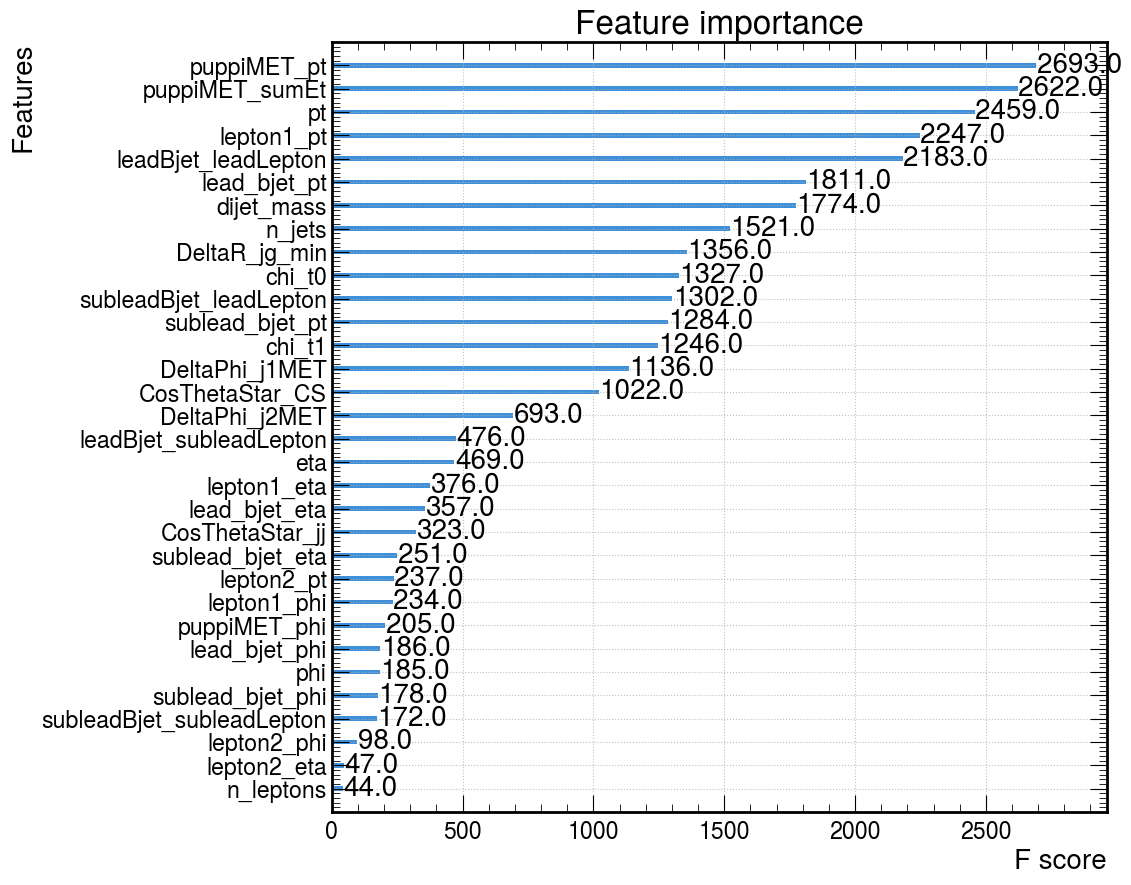

In [53]:
xgb.plot_importance(booster)

In [54]:
import graphviz
xgb.to_graphviz(booster)

ModuleNotFoundError: No module named 'graphviz'

Saved ROC.
BDT performance
Threshold 	Signal Efficiency 	Background contamination
-0.1169  	   0.96   		  0.4249
-0.09705  	   0.94   		  0.3544
-0.09088  	   0.935   		  0.3338
-0.06616  	   0.9   		  0.2547
0.0121  	   0.7   		  0.08297
0.06435  	   0.5   		  0.02809
0.1175  	   0.3003   		  0.007152


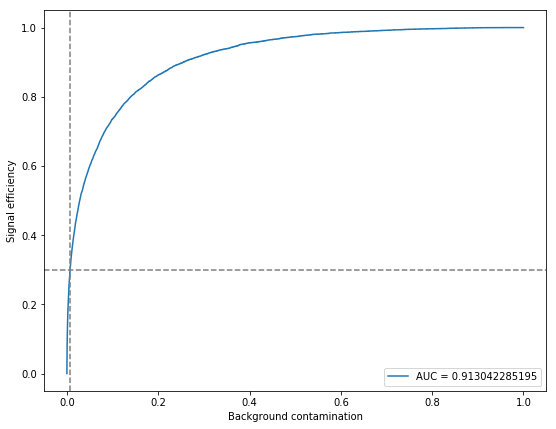

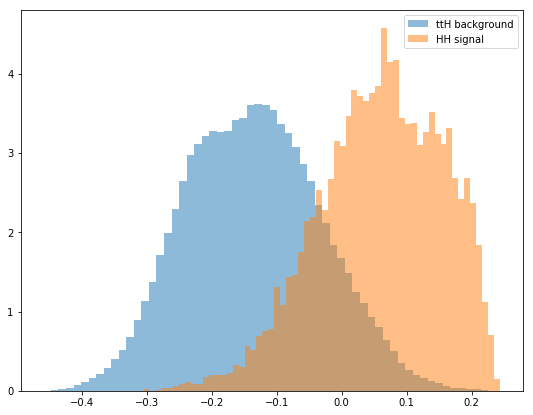

In [ ]:
bdtfile = rt.TFile.Open("TMVA.root")
bdttree = bdtfile.Get("TestTree")
bdtscore = tree2array(bdttree,
                        branches = ['classID','BDT'])
bdtframe = pd.DataFrame.from_records(bdtscore)
bdtarray = bdtframe.values

bdt_pred = bdtarray[:,1]
bdt_target = np.zeros(shape=len(bdt_pred))
bdt_target[bdtarray[:,0]==0] = 1 # Signal
bdt_target[bdtarray[:,0]==1] = -1 # Background

fpr_bdt, tpr_bdt, thresholds_bdt = roc_curve(bdt_target, bdt_pred)
area_bdt = auc(fpr_bdt, tpr_bdt)

with h5py.File("BDT_ROC.h5","w") as out:
    out['FPR'] = fpr_bdt
    out['TPR'] = tpr_bdt
    out['Thresholds'] = thresholds_bdt
    print("Saved ROC.")

TPR_thresholds = [0.96, 0.94, 0.935, 0.9, 0.7, 0.5, 0.3]
print("BDT performance")
print("Threshold \tSignal Efficiency \tBackground contamination")
for TPR_threshold in TPR_thresholds:
    thres_bdt_idx = np.argmax(tpr_bdt>TPR_threshold)
    print("{0:.4}  \t   {1:.4}   \t\t  {2:.4}".format(thresholds_bdt[thres_bdt_idx], tpr_bdt[thres_bdt_idx],  fpr_bdt[thres_bdt_idx]))


# TPR_threshold = 0.96
# thres_bdt_idx = np.argmax(tpr_bdt>TPR_threshold)
# print("Signal efficiency = {} @ {} ttH background contamination".format(tpr_bdt[thres_bdt_idx], fpr_bdt[thres_bdt_idx]))
# print("NN score threshold = {}".format(thresholds_bdt[thres_bdt_idx]))

plt.figure(figsize=(9,7))
plt.plot(fpr_bdt,tpr_bdt,label="AUC = {}".format(area_bdt))
plt.legend(loc='best')
plt.xlabel('Background contamination')
plt.ylabel('Signal efficiency')
plt.axhline(tpr_bdt[thres_bdt_idx],ls='--',color='tab:gray')
plt.axvline(fpr_bdt[thres_bdt_idx],ls='--',color='tab:gray')

plt.figure(figsize=(9,7))
plt.hist(bdt_pred[bdt_target==-1], bins=60, label='ttH background',alpha=0.5, normed=True)
plt.hist(bdt_pred[bdt_target==1], bins=60, label='HH signal', alpha=0.5, normed=True)
#plt.axvline(thresholds_bdt[thres_bdt_idx], ls='--',color='tab:gray')
plt.legend(loc='best')